<a href="https://colab.research.google.com/github/ReemAbdelhaleemHassan/Speech-Emotion-Recognition/blob/main/mel_spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Reading from Google Drive**

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Upload the dataset**

In [ ]:
link = 'https://drive.google.com/file/d/1LHwz3Nl6cFkdQOpDlwu-pYklLzerGP79/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Crema.zip')

## **Unzipping**

In [ ]:
! unzip Crema.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1031_DFA_DIS_XX.wav  
  inflating: Crema/1031_DFA_FEA_XX.wav  
  inflating: Crema/1031_DFA_HAP_XX.wav  
  inflating: Crema/1031_DFA_NEU_XX.wav  
  inflating: Crema/1031_DFA_SAD_XX.wav  
  inflating: Crema/1031_IEO_ANG_HI.wav  
  inflating: Crema/1031_IEO_ANG_LO.wav  
  inflating: Crema/1031_IEO_ANG_MD.wav  
  inflating: Crema/1031_IEO_DIS_HI.wav  
  inflating: Crema/1031_IEO_DIS_LO.wav  
  inflating: Crema/1031_IEO_DIS_MD.wav  
  inflating: Crema/1031_IEO_FEA_HI.wav  
  inflating: Crema/1031_IEO_FEA_LO.wav  
  inflating: Crema/1031_IEO_FEA_MD.wav  
  inflating: Crema/1031_IEO_HAP_HI.wav  
  inflating: Crema/1031_IEO_HAP_LO.wav  
  inflating: Crema/1031_IEO_HAP_MD.wav  
  inflating: Crema/1031_IEO_NEU_XX.wav  
  inflating: Crema/1031_IEO_SAD_HI.wav  
  inflating: Crema/1031_IEO_SAD_LO.wav  
  inflating: Crema/1031_IEO_SAD_MD.wav  
  inflating: Crema/1031_IOM_ANG_XX.wav  
  inflating: Crema/1031_IOM_DIS_XX.wav  
  infl

## **Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wave, sys
import librosa
import librosa.display
from IPython.display import Audio
from IPython.display import display
import os
import soundfile as sf
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



##**Creating dataframe**

In [ ]:
def read_data(root):
  data = []

  directory = os.fsencode(root)
  for file in os.listdir(directory):
      filename = os.fsdecode(file)
      filename= root + filename
      data.append([filename,filename[24:27]])
  return pd.DataFrame(data, columns = ['File_path', 'Class'])

In [ ]:
data_df = read_data("/content/Crema/")

## **Constants**

In [ ]:
# FRAME_LENGTH = 1024         # default 2048
# HOP_LENGTH = 256            # default 512
SAMPLING_RATE = 22050       # default 22050
EPOCHS = 20
BATCH_SIZE = 8
LEARNING_RATE = 0.0001

In [ ]:
def mel_spectrogram(x):
  S = librosa.feature.melspectrogram(y=x)
  return S

In [ ]:
def extract_label(label_string):
  map = {
      "SAD":0,
      "ANG":1,
      "DIS":2,
      "FEA":3,
      "HAP":4,
      "NEU":5
  }
  return map[label_string]

In [ ]:
def audio_equalling(data_df):
  samples = []
  labels = []
  min_len = np.Inf               # minimum length =27959 when sr=22050
  equalled_samples = []

  # to get the length of smallest audio file
  for i in range(len(data_df)):
    samples.append(librosa.load(data_df['File_path'][i],sr=SAMPLING_RATE)[0])
    min_len = min(min_len,len(samples[i]))

  # add zero padding vector equal to difference between maximum audio and audio length
  # samples = np.array(samples)
  # for i in range(len(samples)):
  #   samples[i] = np.concatenate((samples[i],np.zeros(max_len - len(samples[i]))),axis=0)

  # divde the samples according to the smallest audio length and clip the incompleted samples assuming most of the audio files contain no information at the end of the audio
  # to do zero padding for the neglicting part
  for i in range(len(samples)):
    it = len(samples[i]) // min_len
    label = extract_label(data_df["Class"][i])
    for j in range(it):
      equalled_samples.append(samples[i][j*min_len+1:(j+1)*min_len])
      labels.append(label)

  return equalled_samples,np.array(labels)

In [ ]:
def create_feature_spaces(samples):
  d1 = []
  d2 = []

  # samples,labels = audio_equalling(data_df)
  for i in range(len(samples)):
      # d1.append(np.concatenate((samples[i],custom_features(samples[i]))))
      d2.append(mel_spectrogram(samples[i]))

  # TODO identify the datatype for the numpy
  return np.array(d1),np.array(d2)

In [ ]:
samples,labels = audio_equalling(data_df)         # takes around 6-8 mins

In [ ]:
print(np.array(samples).shape)

(10902, 27958)


In [ ]:
d1,d2 = create_feature_spaces(samples)

In [ ]:
d2.shape

(10902, 128, 55)

In [ ]:
d2_reshaped = np.reshape(d2,(d2.shape[0],1,d2.shape[1],d2.shape[2]))

In [ ]:
d2_reshaped.shape

(10902, 1, 128, 55)

In [ ]:
labels.shape

In [ ]:
# TODO dataset after pre-processing is unbalanced
train_features, test_features, train_labels, test_labels = train_test_split(d2_reshaped,labels, test_size=0.3, random_state=42,stratify=labels)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.05, random_state=42,stratify=train_labels)

In [ ]:
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=(5,3),stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(5,3), stride=2)

        self.conv2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(5,3),stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(5,3), stride=2)

        self.conv3 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(5,3),stride=1)
        self.pool3 = nn.MaxPool2d(kernel_size=(5,3), stride=2)

        self.fc1 = nn.Linear(in_features=4608,out_features=256)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=256,out_features=6)


    # Defining the forward pass    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.log_softmax(self.fc2(x),dim=0)
        return x

net = Net()

In [ ]:
class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    return torch.tensor(self.feat_arr[index]).float(),torch.tensor((self.label[index]))
    #TODO
  def __len__(self):
    return len(self.feat_arr)

In [ ]:
train_dataset = dataset(train_features,train_labels)
val_dataset = dataset(val_features,val_labels)

# TODO what is num_worker do
train_dataloader = DataLoader(train_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)
val_dataloader = DataLoader(val_dataset,batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
from tqdm import tqdm
from collections import defaultdict
def train_model(model, train_dataloader, val_dataloader):
    
    
    # to store the results
    summary = defaultdict(list)
    # to select GPU for running
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # identifying the loss and optimizer funtions for weights calculations
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  

    # to apply the gpu for the model and loss functions
    if use_cuda:
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for inputs, labels in tqdm(train_dataloader):

                optimizer.zero_grad()
                train_labels = labels.to(device)
                train_inputs = inputs.to(device)

                output = model(train_inputs)
                
                batch_loss = criterion(output, train_labels)
                total_loss_train += float(batch_loss.item())
                
                acc = (output.argmax(dim=1) == train_labels).sum().item()
                total_acc_train += float(acc)
                del acc


                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            # scheduler.step()
            total_acc_val = 0
            total_loss_val = 0

            # Disabling gradient calculation is useful for inference to avoid dependency
            with torch.no_grad():

                # repreat for the previous but for the validation set 
                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += float(batch_loss.item())
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += float(acc)
                    del acc
                
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_features): .3f} | Train Accuracy: {total_acc_train / len(train_features): .3f} | Val Loss: {total_loss_val / len(val_features): .3f} | Val Accuracy: {total_acc_val / len(val_features): .3f}')
            

            summary['train_acc'].append(total_acc_train/len(train_features))
            summary['train_loss'].append(total_loss_train/len(train_features))
            summary['val_acc'].append(total_acc_val/len(val_features))
            summary['val_loss'].append(total_loss_val/len(val_features))

    return model,summary

In [ ]:
net,history = train_model(net,train_dataloader,val_dataloader)

100%|██████████| 907/907 [01:20<00:00, 11.29it/s]


Epochs: 1 | Train Loss:  0.253 | Train Accuracy:  0.298 | Val Loss:  0.214 | Val Accuracy:  0.348


100%|██████████| 907/907 [01:21<00:00, 11.10it/s]


Epochs: 2 | Train Loss:  0.203 | Train Accuracy:  0.339 | Val Loss:  0.193 | Val Accuracy:  0.361


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 3 | Train Loss:  0.194 | Train Accuracy:  0.354 | Val Loss:  0.189 | Val Accuracy:  0.374


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 4 | Train Loss:  0.191 | Train Accuracy:  0.363 | Val Loss:  0.187 | Val Accuracy:  0.374


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 5 | Train Loss:  0.188 | Train Accuracy:  0.373 | Val Loss:  0.187 | Val Accuracy:  0.364


100%|██████████| 907/907 [01:22<00:00, 11.05it/s]


Epochs: 6 | Train Loss:  0.186 | Train Accuracy:  0.374 | Val Loss:  0.183 | Val Accuracy:  0.411


100%|██████████| 907/907 [01:21<00:00, 11.06it/s]


Epochs: 7 | Train Loss:  0.184 | Train Accuracy:  0.390 | Val Loss:  0.183 | Val Accuracy:  0.395


100%|██████████| 907/907 [01:22<00:00, 11.05it/s]


Epochs: 8 | Train Loss:  0.183 | Train Accuracy:  0.391 | Val Loss:  0.191 | Val Accuracy:  0.385


100%|██████████| 907/907 [01:22<00:00, 11.04it/s]


Epochs: 9 | Train Loss:  0.181 | Train Accuracy:  0.392 | Val Loss:  0.183 | Val Accuracy:  0.356


100%|██████████| 907/907 [01:22<00:00, 11.03it/s]


Epochs: 10 | Train Loss:  0.178 | Train Accuracy:  0.408 | Val Loss:  0.185 | Val Accuracy:  0.401


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 11 | Train Loss:  0.177 | Train Accuracy:  0.411 | Val Loss:  0.183 | Val Accuracy:  0.390


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 12 | Train Loss:  0.174 | Train Accuracy:  0.419 | Val Loss:  0.188 | Val Accuracy:  0.390


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 13 | Train Loss:  0.170 | Train Accuracy:  0.435 | Val Loss:  0.188 | Val Accuracy:  0.419


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 14 | Train Loss:  0.171 | Train Accuracy:  0.437 | Val Loss:  0.185 | Val Accuracy:  0.432


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 15 | Train Loss:  0.168 | Train Accuracy:  0.448 | Val Loss:  0.191 | Val Accuracy:  0.421


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 16 | Train Loss:  0.164 | Train Accuracy:  0.468 | Val Loss:  0.197 | Val Accuracy:  0.421


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 17 | Train Loss:  0.161 | Train Accuracy:  0.470 | Val Loss:  0.201 | Val Accuracy:  0.395


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 18 | Train Loss:  0.158 | Train Accuracy:  0.485 | Val Loss:  0.205 | Val Accuracy:  0.427


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 19 | Train Loss:  0.158 | Train Accuracy:  0.491 | Val Loss:  0.203 | Val Accuracy:  0.406


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 20 | Train Loss:  0.152 | Train Accuracy:  0.505 | Val Loss:  0.216 | Val Accuracy:  0.401


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 21 | Train Loss:  0.149 | Train Accuracy:  0.517 | Val Loss:  0.215 | Val Accuracy:  0.424


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 22 | Train Loss:  0.146 | Train Accuracy:  0.527 | Val Loss:  0.243 | Val Accuracy:  0.401


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 23 | Train Loss:  0.150 | Train Accuracy:  0.520 | Val Loss:  0.214 | Val Accuracy:  0.393


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 24 | Train Loss:  0.144 | Train Accuracy:  0.543 | Val Loss:  0.229 | Val Accuracy:  0.414


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 25 | Train Loss:  0.138 | Train Accuracy:  0.560 | Val Loss:  0.235 | Val Accuracy:  0.419


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 26 | Train Loss:  0.137 | Train Accuracy:  0.567 | Val Loss:  0.264 | Val Accuracy:  0.393


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 27 | Train Loss:  0.140 | Train Accuracy:  0.564 | Val Loss:  0.258 | Val Accuracy:  0.403


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 28 | Train Loss:  0.134 | Train Accuracy:  0.583 | Val Loss:  0.265 | Val Accuracy:  0.377


100%|██████████| 907/907 [01:22<00:00, 10.97it/s]


Epochs: 29 | Train Loss:  0.129 | Train Accuracy:  0.595 | Val Loss:  0.296 | Val Accuracy:  0.398


100%|██████████| 907/907 [01:22<00:00, 10.97it/s]


Epochs: 30 | Train Loss:  0.131 | Train Accuracy:  0.590 | Val Loss:  0.282 | Val Accuracy:  0.377


100%|██████████| 907/907 [01:22<00:00, 10.97it/s]


Epochs: 31 | Train Loss:  0.125 | Train Accuracy:  0.604 | Val Loss:  0.298 | Val Accuracy:  0.395


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 32 | Train Loss:  0.127 | Train Accuracy:  0.604 | Val Loss:  0.314 | Val Accuracy:  0.387


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 33 | Train Loss:  0.121 | Train Accuracy:  0.620 | Val Loss:  0.297 | Val Accuracy:  0.403


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 34 | Train Loss:  0.122 | Train Accuracy:  0.628 | Val Loss:  0.386 | Val Accuracy:  0.382


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 35 | Train Loss:  0.116 | Train Accuracy:  0.629 | Val Loss:  0.399 | Val Accuracy:  0.353


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 36 | Train Loss:  0.115 | Train Accuracy:  0.639 | Val Loss:  0.398 | Val Accuracy:  0.393


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 37 | Train Loss:  0.112 | Train Accuracy:  0.646 | Val Loss:  0.399 | Val Accuracy:  0.385


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 38 | Train Loss:  0.110 | Train Accuracy:  0.661 | Val Loss:  0.400 | Val Accuracy:  0.372


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 39 | Train Loss:  0.116 | Train Accuracy:  0.659 | Val Loss:  0.407 | Val Accuracy:  0.432


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 40 | Train Loss:  0.106 | Train Accuracy:  0.666 | Val Loss:  0.425 | Val Accuracy:  0.401


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 41 | Train Loss:  0.101 | Train Accuracy:  0.682 | Val Loss:  0.499 | Val Accuracy:  0.372


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 42 | Train Loss:  0.108 | Train Accuracy:  0.674 | Val Loss:  0.415 | Val Accuracy:  0.429


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 43 | Train Loss:  0.106 | Train Accuracy:  0.675 | Val Loss:  0.418 | Val Accuracy:  0.361


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 44 | Train Loss:  0.100 | Train Accuracy:  0.690 | Val Loss:  0.474 | Val Accuracy:  0.348


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 45 | Train Loss:  0.097 | Train Accuracy:  0.699 | Val Loss:  0.449 | Val Accuracy:  0.380


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 46 | Train Loss:  0.092 | Train Accuracy:  0.711 | Val Loss:  0.512 | Val Accuracy:  0.382


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 47 | Train Loss:  0.096 | Train Accuracy:  0.704 | Val Loss:  0.570 | Val Accuracy:  0.359


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 48 | Train Loss:  0.102 | Train Accuracy:  0.693 | Val Loss:  0.544 | Val Accuracy:  0.395


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 49 | Train Loss:  0.089 | Train Accuracy:  0.721 | Val Loss:  0.606 | Val Accuracy:  0.330


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 50 | Train Loss:  0.093 | Train Accuracy:  0.722 | Val Loss:  0.542 | Val Accuracy:  0.382


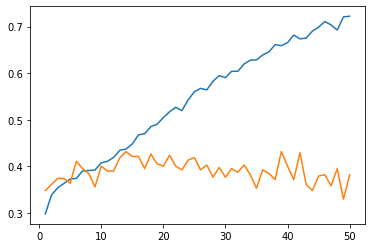

In [ ]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, endpoint=True)
plt.plot(x_axis, history['train_acc'])
plt.plot(x_axis, history['val_acc'])

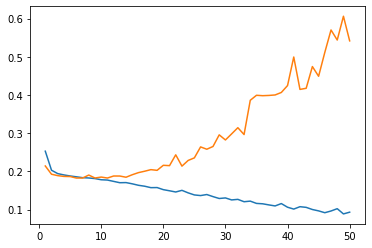

In [ ]:
plt.plot(x_axis, history['train_loss'])
plt.plot(x_axis, history['val_loss'])

In [ ]:
net,history = train_model(net,train_dataloader,val_dataloader)

100%|██████████| 907/907 [01:23<00:00, 10.89it/s]


Epochs: 1 | Train Loss:  0.314 | Train Accuracy:  0.289 | Val Loss:  0.275 | Val Accuracy:  0.335


100%|██████████| 907/907 [01:22<00:00, 10.94it/s]


Epochs: 2 | Train Loss:  0.208 | Train Accuracy:  0.319 | Val Loss:  0.198 | Val Accuracy:  0.314


100%|██████████| 907/907 [01:22<00:00, 10.96it/s]


Epochs: 3 | Train Loss:  0.197 | Train Accuracy:  0.345 | Val Loss:  0.206 | Val Accuracy:  0.332


100%|██████████| 907/907 [01:22<00:00, 10.96it/s]


Epochs: 4 | Train Loss:  0.195 | Train Accuracy:  0.345 | Val Loss:  0.189 | Val Accuracy:  0.346


100%|██████████| 907/907 [01:22<00:00, 10.96it/s]


Epochs: 5 | Train Loss:  0.194 | Train Accuracy:  0.353 | Val Loss:  0.189 | Val Accuracy:  0.380


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 6 | Train Loss:  0.191 | Train Accuracy:  0.360 | Val Loss:  0.186 | Val Accuracy:  0.364


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 7 | Train Loss:  0.192 | Train Accuracy:  0.361 | Val Loss:  0.185 | Val Accuracy:  0.382


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 8 | Train Loss:  0.190 | Train Accuracy:  0.370 | Val Loss:  0.188 | Val Accuracy:  0.356


100%|██████████| 907/907 [01:22<00:00, 10.98it/s]


Epochs: 9 | Train Loss:  0.189 | Train Accuracy:  0.369 | Val Loss:  0.181 | Val Accuracy:  0.406


100%|██████████| 907/907 [01:22<00:00, 10.99it/s]


Epochs: 10 | Train Loss:  0.186 | Train Accuracy:  0.373 | Val Loss:  0.185 | Val Accuracy:  0.387


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 11 | Train Loss:  0.186 | Train Accuracy:  0.383 | Val Loss:  0.184 | Val Accuracy:  0.377


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 12 | Train Loss:  0.184 | Train Accuracy:  0.385 | Val Loss:  0.183 | Val Accuracy:  0.348


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 13 | Train Loss:  0.181 | Train Accuracy:  0.390 | Val Loss:  0.185 | Val Accuracy:  0.346


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 14 | Train Loss:  0.180 | Train Accuracy:  0.396 | Val Loss:  0.191 | Val Accuracy:  0.385


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 15 | Train Loss:  0.181 | Train Accuracy:  0.407 | Val Loss:  0.184 | Val Accuracy:  0.395


100%|██████████| 907/907 [01:22<00:00, 11.01it/s]


Epochs: 16 | Train Loss:  0.179 | Train Accuracy:  0.404 | Val Loss:  0.184 | Val Accuracy:  0.387


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 17 | Train Loss:  0.176 | Train Accuracy:  0.414 | Val Loss:  0.185 | Val Accuracy:  0.414


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 18 | Train Loss:  0.175 | Train Accuracy:  0.422 | Val Loss:  0.193 | Val Accuracy:  0.416


100%|██████████| 907/907 [01:22<00:00, 11.02it/s]


Epochs: 19 | Train Loss:  0.173 | Train Accuracy:  0.420 | Val Loss:  0.193 | Val Accuracy:  0.390


100%|██████████| 907/907 [01:22<00:00, 11.00it/s]


Epochs: 20 | Train Loss:  0.171 | Train Accuracy:  0.432 | Val Loss:  0.191 | Val Accuracy:  0.377


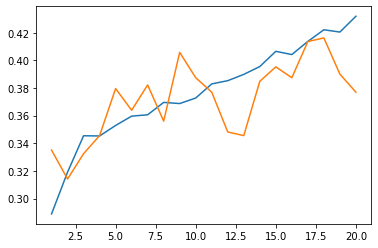

In [ ]:
x_axis = np.linspace(1, EPOCHS, EPOCHS, endpoint=True)
plt.plot(x_axis, history['train_acc'])
plt.plot(x_axis, history['val_acc'])

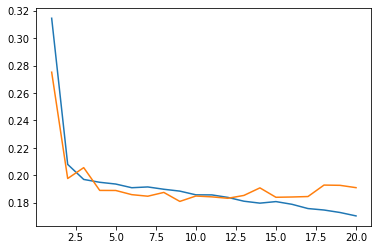

In [ ]:
plt.plot(x_axis, history['train_loss'])
plt.plot(x_axis, history['val_loss'])

In [ ]:
def test_model(model, test_dataloader):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    y_pred=[]
    y_true=[]

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    # Disabling gradient calculation is useful for inference to avoid dependency
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              test_input = test_input.to(device)
              output = model(test_input)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              
              y_pred.extend((torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()) # Save Prediction
      
              test_label = test_label.data.cpu().numpy()
              y_true.extend(test_label) # Save Truth

            
    print(f'Test Accuracy: {total_acc_test / len(test_features): .3f}')
    return y_pred, y_true, total_acc_test / len(test_features)

In [ ]:
test_dataloader = DataLoader(dataset(test_features,test_labels),batch_size = BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
y_pred,y_true,total_acc = test_model(net,test_dataloader)
f1_score(y_true, y_pred, average=None)

Test Accuracy:  0.383


array([0.51146132, 0.56395349, 0.21009269, 0.23529412, 0.25663717,
       0.36770428])

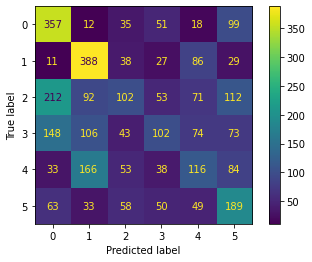

In [ ]:
confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()